In [74]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import gurobipy as grb
from gurobipy import GRB

# Input Problem Parameters

## Import du problème

In [75]:
from utils.extract_parameters import extract_parameters

################################
######## TO DO #################
################################

# choose taille among: "small", "medium", "large"
taille = "large"

In [76]:
################################
######## DO NOT CHANGE #########
################################
map_employe_indice, map_job_indice, map_qualif_indice, conge, qualif, d, p, b, besoin = extract_parameters(taille)

In [77]:
print("conge : ",conge)
print("qualif : ",qualif)
print("date livraison : ",d)
print("pénalité : ",p)
print("bénéfice : ",b)
print("besoin : ",besoin)

conge :  [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]]
qualif :  [[1, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 0], [0, 1, 0, 1, 0, 0], [0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 1, 1], [0, 0, 0, 1, 1, 1], [0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 1, 1]]
date livraison :  [26, 20, 32, 32, 26, 30, 26, 36, 18, 18, 22, 26, 18, 12, 28, 26, 12, 14, 14, 16, 18, 14, 32, 18, 30]


## Définissons les paramètres

In [78]:
from utils.define_nums import define_nums

nombre_employes, horizon, nombre_qualifs, nombre_projets = define_nums(conge, qualif, d, p, b, besoin)

In [79]:
print("nombre_employes : ",nombre_employes)
print("horizon : ",horizon)
print("nombre_qualifs : ",nombre_qualifs)
print("nombre_projets : ",nombre_projets)

nombre_employes :  6
horizon :  36
nombre_qualifs :  10
nombre_projets :  25


In [80]:
## u_j, le projet j est réalisé
u_shape = nombre_projets

## x_i_j_k_n, l'employé k travaille sur le projet j avec la qualif i
## au jour n
x_shape = [(i,j,k, n) for i in range(nombre_qualifs) for j in range(nombre_projets) for k in range(nombre_employes) for n in range(horizon)]

## t_k_j, l'employé k travaille sur le projet j
t_shape = [(i,j) for i in range(nombre_employes) for j in range(nombre_projets)]

## begin_j, la date de début effective
begin_shape = nombre_projets

## end_j, la date de fin effective = date de livraison du projet j
end_shape = nombre_projets

## delay_j, le nombre de jours de retard par projet j
delay_shape = nombre_projets

## longueur_j, la longueur du projet j
longueur_shape = nombre_projets

## projet_par_employe_k, le nombre de projet par employe
projet_par_employe_shape = nombre_employes

# majorant pour la contrainte de couverture
maj = max([besoin[i][j] for j in range(nombre_projets) for i in range(nombre_qualifs)]) + 1

# si le projet j est travaillé au jour n
job_in_process_shape = [(j, n) for j in range(nombre_projets) for n in range(horizon)]

# Model deployment

## Add the variables

In [81]:
model = grb.Model("Planning")

# L'affectation du planning, la variable clé
x = model.addVars(x_shape, vtype=GRB.BINARY, name="x")

## Les dates de fin des projets
dateFin = model.addVars(end_shape, lb = 0, ub = horizon, name = "dateFin")

## Les dates de début des projets
dateDebut = model.addVars(begin_shape, lb = 0, ub = horizon, name = "dateDebut")

## Le nombre de jours de delai
delay = model.addVars(delay_shape, lb = 0, ub = horizon, name = "delay")

## Les longueurs des projets
longueur = model.addVars(longueur_shape, lb = 0, ub = horizon, name = "longueur")

## Nombre de projet par employé
projet_par_employe = model.addVars(projet_par_employe_shape, lb = 0, ub = nombre_projets, name = "projet_par_employe")

## L'affectation sur un projet d'un employé
affectation = model.addVars(t_shape, vtype = GRB.BINARY, name = "affectation")

## La réalisation ou non d'un projet
u = model.addVars(u_shape, vtype = GRB.BINARY, name="u")

## Verification du projet
job_in_process = model.addVars(job_in_process_shape, vtype = GRB.BINARY, name = "job_in_process")

In [82]:
# Update le modele pour confirmer la création des variables
model.update()


## Add constraints

In [83]:
for i in range(nombre_qualifs):
    for j in range(nombre_projets):
        for k in range(nombre_employes):
            for n in range(horizon):
                ## La qualification du personnel
                model.addConstr( x[i,j,k,n] <= qualif[i][k], name="QualificationPersonnel[{0}{1}{2}{3}]".format(i,j,k,n))
                model.addConstr( x[i,j,k,n] <= (besoin[i][j] >=1), name = "BesoinQualifPersonnel[{0}{1}{2}{3}]".format(i,j,k,n))
                ## Contraintes des congés
                model.addConstr( x[i,j,k,n] <= conge[k][n], name=f"CongesPersonnel[{i}{j}{k}{n}]")
        
        ## Contrainte d'unicité de réalisation d'un projet
        model.addConstr(grb.quicksum(grb.quicksum(x[i,j,k,n] for n in range(horizon)) for k in range(nombre_employes)) == besoin[i][j]*u[j], name=f"UniciteRealisation[{i}{j}]")

        ## Couverture des qualifications
        # model.addConstr( grb.quicksum(grb.quicksum(x[i,j,k,n] for n in range(horizon)) for k in range(nombre_employes)) - besoin[i][j] >= maj*(1-u[j]), name=f"CouvertureQualificationsInf[{i}{j}]") 


## Unicité de l'affectation quotidienne
for k in range(nombre_employes):
    for n in range(horizon):
        model.addConstr(grb.quicksum(grb.quicksum(x[i,j,k,n] for j in range(nombre_projets)) for i in range(nombre_qualifs)) <= 1, name=f"UniciteAffectation[{k}{n}]")

        
for j in range(nombre_projets):
    for n in range(horizon):
        model.addConstrs(((job_in_process[j,n] >= x[i,j,k,n]) for i in range(nombre_qualifs) for k in range(nombre_employes)), name=f"ContrainteJobInProcess[{j}{n}]")
    # start date
    model.addConstrs(((dateDebut[j] <= job_in_process[j,n]*n) for n in range(horizon)), name = f"ContrainteDateDebut[{j}]")

    # end date
    model.addConstrs(((job_in_process[j,n]*n <= dateFin[j]) for n in range(horizon)), name=f"FinProjet[{j}]")

    ## longueur
    model.addConstr(longueur[j] == dateFin[j] - dateDebut[j], name=f"LongueurProjet[{j}]")

    ## delay
    model.addConstr(delay[j] >= dateFin[j] - (d[j] - 1), name=f"DelaiProjet_difference[{j}]")    

## projet_par_employe
for k in range(nombre_employes):
    model.addConstr(projet_par_employe[k] == grb.quicksum( affectation[k,j] for j in range(nombre_projets)), name=f"FinProjet[{j}]")
    
    
## Contrainte de l'affectation à un projet selon les jours de travail
for k in range(nombre_employes):
    for j in range(nombre_projets):
        model.addConstr(affectation[k,j] <= grb.quicksum(grb.quicksum(x[i,j,k,n] for i in range(nombre_qualifs)) for n in range(horizon)), name=f"AffectationProjetQuicksum[{k}{j}]")    

## Fonctions objectif

In [84]:
## bénéfice total
benefice_tot = grb.quicksum( (b[j]*u[j] - delay[j]*p[j]) for j in range(nombre_projets) )

## Lignes pour optimiser le modèles
## sur le bénéfice total seulement

# model.ModelSense = GRB.MAXIMIZE
# model.setObjective(benefice_tot)
# model.ModelSense = GRB.MAXIMIZE

In [85]:
# Lignes pour optimiser le problème suivant
## les trois fonctions objectif voulues

# Nombre de projet maximum par personne
projet_max = model.addVar(lb= 0, ub=nombre_projets, name="projet_max")
model.addConstrs(projet_max>=projet_par_employe[k] for k in range(nombre_employes))

# Compacité des projets
longueur_max = model.addVar(lb = 0, ub=horizon, name="longueur_max")
model.addConstrs(longueur_max>=longueur[j] for j in range(nombre_projets))

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [86]:
model.update()

In [87]:
res = pd.DataFrame(columns = ["Benefice", "longueur max", "projets max"])

for l in range(horizon-1, 0 , -1):
    for p in range(nombre_projets-1, 0, -1):
        # contrainte sur la longueur des projets
        model.addConstr(longueur_max<=l)
        # contrainte sur le nombre de projets
        model.addConstr(projet_max<=p)

        model.ModelSense = GRB.MAXIMIZE
        model.setObjective(benefice_tot)
        model.ModelSense = GRB.MAXIMIZE
        model.optimize()

        res.loc[len(res)] = [model.objVal, l, p]
        
        model.resetParams()


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 218505 rows, 55183 columns and 436105 nonzeros
Model fingerprint: 0x0e14dbde
Variable types: 108 continuous, 55075 integer (55075 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [3e+00, 8e+01]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 216923 rows and 50865 columns
Presolve time: 0.54s
Presolved: 1582 rows, 4318 columns, 11015 nonzeros
Variable types: 0 continuous, 4318 integer (4294 binary)

Root relaxation: objective 8.368416e+02, 3417 iterations, 0.23 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

In [88]:
res.head()

,Benefice,longueur max,projets max
0,817.0,35.0,24.0
1,817.0,35.0,23.0
2,817.0,35.0,22.0
3,817.0,35.0,21.0
4,817.0,35.0,20.0


# Model optimisation

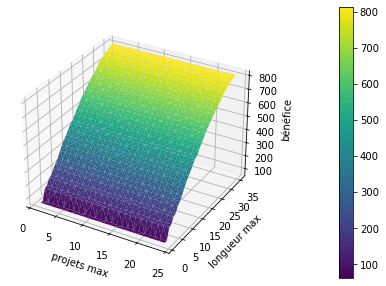

In [89]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X, Y = np.meshgrid(res["projets max"], res["longueur max"])
Z = res["Benefice"]

X = np.array(res["projets max"])
Y = np.array(res["longueur max"])
Z = np.array(res["Benefice"])

# Plot the surface.
surf = ax.plot_trisurf(X, Y, Z, cmap = 'viridis'
                       #linewidth=0, antialiased=False
                       )

# Add a color bar which maps values to colors.
fig.colorbar(surf, pad=0.2)

ax.set_xlabel('projets max')
ax.set_ylabel('longueur max')
ax.set_zlabel('bénéfice')

fig.set_size_inches(7, 5)

if taille == "small":
    plt.savefig("results/sys_preference/small.png")
elif taille=="medium":
    plt.savefig("results/sys_preference/medium.png")
else:
    plt.savefig("results/sys_preference/large.png")

plt.show()

In [90]:
# Verify model formulation

#nom = "results/"+taille+".lp"
#model.write(nom)

# Run optimization engine

model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 220183 rows, 55183 columns and 437783 nonzeros
Model fingerprint: 0x2024c8cc
Variable types: 108 continuous, 55075 integer (55075 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [3e+00, 8e+01]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]


Presolve removed 220183 rows and 55183 columns
Presolve time: 0.41s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.72 seconds (0.25 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 60 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.000000000000e+01, best bound 6.000000000000e+01, gap 0.0000%


In [91]:
## Print the values of all variables
# for v in model.getVars():
#     print(f"{v.VarName} = {v.X}")

# Pour voir quels sont les projets faits
# for j in range(nombre_projets):
#     v = model.getVarByName(f"u[{j}]")
#     if int(v.x) == 1:
#         print(f"la tâche {j} est faite")
#     else:
#         print(f"la tâche {j} n'est pas faite")

In [92]:
# Edt des employés et le détail de la réalisation de chaque tâche (de façon ordonnée)

schedules = []
tasks_performances = []
for i in range(nombre_qualifs):
    for j in range(nombre_projets):
        for k in range(nombre_employes):
            for n in range(horizon):
                v = model.getVarByName(f"x[{i},{j},{k},{n}]")
                if int(v.x) == 1:
                    schedules.append((map_employe_indice[k], n+1, map_job_indice[j], map_qualif_indice[i]))
                    tasks_performances.append((map_job_indice[j], map_qualif_indice[i], map_employe_indice[k], n+1))

schedules.sort()

tasks_performances.sort()

# Dates de début et de fin des tâches réalisees 
# (à n'étudier que lorsque longueur_max est mis en objectif, sinon les 
# variables dateDebut et dateFin ne sont pas assez contraintes pour prendre exactement le sens souhaité)

# for j in range(nombre_projets):
#     v = model.getVarByName(f"u[{j}]")
#     v1 = model.getVarByName(f"dateDebut[{j}]")
#     v2 = model.getVarByName(f"dateFin[{j}]")
#     if int(v.x) == 1:
#         print(f"la tâche {j} commence à la date {int(1+v1.x)} et finit à la date {int(1+v2.x)}")

In [93]:
from utils.show_planning import show_planning

df = pd.DataFrame(schedules, columns=['Nom', 'Jour', 'Projet', 'Qualification'])
show_planning(df)

In [94]:
## Avec seulement le bénéfice à optimiser
## Commenter lors de la recherche de solutions non dominées

# if taille == "small":
#     df.to_json(r'results/benefice/small_benefice.json')
# elif taille=="medium":
#     df.to_json(r'results/benefice/medium_benefice.json')
# else:
#     df.to_json(r'results/benefice/large_benefice.json')

In [95]:
model.objVal

60.0

In [96]:
####################
#### RESULTS #######
####################


## Bénéfice totale (small) = 65
## Bénéfice totale (medium) = 413
## Bénéfice totale (large) = 817